# Exploring GraphSAGE link prediction model for drug-drug interactions

## Loading the Drug-Drug network data

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 440kB 7.6MB/s 
     |████████████████████████████████| 235kB 14.7MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.calibration import expected_calibration_error, plot_reliability_diagram
from stellargraph.calibration import IsotonicCalibration, TemperatureCalibration

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

from sklearn.metrics import accuracy_score

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

## Global parameters
Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [ ]:
batch_size = 50
epochs = 20  # The number of training epochs for training the GraphSAGE model.

# train, test, validation split
train_size = 0.2
test_size = 0.15
val_size = 0.2

## Loading the Drug-Drug network data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!mkdir ./Effectants/
!cp -r "drive/My Drive/GNN/GNN" ./Effectants/

Mounted at /content/drive/


In [ ]:
ls Effectants/GNN/

filtered_dataframe_top50.csv
full_drug_graph_cleaned_100.pkl
full_drug_graph_cleaned_50.pkl
full_drug_graph_cleaned_with_node_features_top100.pkl
full_drug_graph_cleaned_with_node_features_top50.pkl
full_drug_graph.pkl
GNN/


In [ ]:
full_drug_graph = nx.read_gpickle("Effectants/GNN/full_drug_graph_cleaned_with_node_features_top50.pkl")

G = StellarGraph.from_networkx(full_drug_graph, node_features='v')

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 645, Edges: 975517

 Node types:
  default: [645]
    Features: float32 vector, length 10829
    Edge types: default-test_104->default, default-test_122->default, default-test_127->default, default-test_130->default, default-test_134->default, ... (45 more)

 Edge types:
    default-test_51->default: [28568]
        Weights: all 1 (default)
        Features: none
    default-test_74->default: [27006]
        Weights: all 1 (default)
        Features: none
    default-test_29->default: [26037]
        Weights: all 1 (default)
        Features: none
    default-test_361->default: [25190]
        Weights: all 1 (default)
        Features: none
    default-test_68->default: [24430]
        Weights: all 1 (default)
        Features: none
    default-test_127->default: [24260]
        Weights: all 1 (default)
        Features: none
    default-test_104->default: [23894]
        Weights: all 1 (default)
        Features: none
    default-test_130->d

From the original graph G, extract a randomly sampled subset of validation edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True, edge_label="test_51"
)

Network has 28568 edges of type test_51
Network has 28568 edges of type test_51
** Sampled 4285 positive and 4285 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the validation data for the model. From the reduced graph G_test, extract a randomly sampled subset of validation edges (true and false citation links) and the reduced graph G_val with the positive train edges removed:

In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_val = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True, edge_label="test_51"
)

Network has 24283 edges of type test_51
Network has 24283 edges of type test_51
** Sampled 4856 positive and 4856 negative edges. **


The reduced graph G_val, together with the validation ground truth set of links (edge_ids_val, edge_labels_val), will be used for validating the model (can also be used to tune the model parameters).

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_val, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_val)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True, edge_label="test_51"
)

Network has 19427 edges of type test_51
Network has 19427 edges of type test_51
** Sampled 3885 positive and 3885 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Summary of G_train, G_val and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [ ]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 645, Edges: 962491

 Node types:
  default: [645]
    Features: float32 vector, length 10829
    Edge types: default-test_104->default, default-test_122->default, default-test_127->default, default-test_130->default, default-test_134->default, ... (45 more)

 Edge types:
    default-test_74->default: [27006]
        Weights: all 1 (default)
        Features: none
    default-test_29->default: [26037]
        Weights: all 1 (default)
        Features: none
    default-test_361->default: [25190]
        Weights: all 1 (default)
        Features: none
    default-test_68->default: [24430]
        Weights: all 1 (default)
        Features: none
    default-test_127->default: [24260]
        Weights: all 1 (default)
        Features: none
    default-test_104->default: [23894]
        Weights: all 1 (default)
        Features: none
    default-test_130->default: [23848]
        Weights: all 1 (default)
        Features: none
    default-test_207->

In [ ]:
print(G_val.info())

StellarGraph: Undirected multigraph
 Nodes: 645, Edges: 966376

 Node types:
  default: [645]
    Features: float32 vector, length 10829
    Edge types: default-test_104->default, default-test_122->default, default-test_127->default, default-test_130->default, default-test_134->default, ... (45 more)

 Edge types:
    default-test_74->default: [27006]
        Weights: all 1 (default)
        Features: none
    default-test_29->default: [26037]
        Weights: all 1 (default)
        Features: none
    default-test_361->default: [25190]
        Weights: all 1 (default)
        Features: none
    default-test_68->default: [24430]
        Weights: all 1 (default)
        Features: none
    default-test_127->default: [24260]
        Weights: all 1 (default)
        Features: none
    default-test_104->default: [23894]
        Weights: all 1 (default)
        Features: none
    default-test_130->default: [23848]
        Weights: all 1 (default)
        Features: none
    default-test_207->

In [ ]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 645, Edges: 971232

 Node types:
  default: [645]
    Features: float32 vector, length 10829
    Edge types: default-test_104->default, default-test_122->default, default-test_127->default, default-test_130->default, default-test_134->default, ... (45 more)

 Edge types:
    default-test_74->default: [27006]
        Weights: all 1 (default)
        Features: none
    default-test_29->default: [26037]
        Weights: all 1 (default)
        Features: none
    default-test_361->default: [25190]
        Weights: all 1 (default)
        Features: none
    default-test_68->default: [24430]
        Weights: all 1 (default)
        Features: none
    default-test_51->default: [24283]
        Weights: all 1 (default)
        Features: none
    default-test_127->default: [24260]
        Weights: all 1 (default)
        Features: none
    default-test_104->default: [23894]
        Weights: all 1 (default)
        Features: none
    default-test_130->d



Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [ ]:
num_samples = [10, 5]

In [ ]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)


GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and dropout.

In [ ]:
layer_sizes = [32, 32]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.2
)

In [ ]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

In [ ]:
logits = link_classification(
    output_dim=1, output_act="linear", edge_embedding_method="ip"
)(x_out)

prediction = keras.layers.Activation(keras.activations.sigmoid)(logits)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Evaluate the initial (untrained) model on the train, val and test sets:

In [ ]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_val_metrics = model.evaluate(val_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

172/172 [==============================] - 47s 270ms/step - loss: 0.7307 - binary_accuracy: 0.4999

Train Set Metrics of the initial (untrained) model:
	loss: 0.7322
	binary_accuracy: 0.4988

Validation Set Metrics of the initial (untrained) model:
	loss: 0.7294
	binary_accuracy: 0.4988

Test Set Metrics of the initial (untrained) model:
	loss: 0.7307
	binary_accuracy: 0.4999


Train the model:

In [ ]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=val_flow, verbose=1, shuffle=True,
)

Epoch 1/20
156/156 [==============================] - 97s 623ms/step - loss: 0.6478 - binary_accuracy: 0.6391 - val_loss: 0.6581 - val_binary_accuracy: 0.6151
Epoch 2/20
156/156 [==============================] - 97s 622ms/step - loss: 0.6327 - binary_accuracy: 0.6694 - val_loss: 0.6526 - val_binary_accuracy: 0.6184
Epoch 3/20
156/156 [==============================] - 97s 622ms/step - loss: 0.6269 - binary_accuracy: 0.6721 - val_loss: 0.6512 - val_binary_accuracy: 0.6203
Epoch 4/20
156/156 [==============================] - 97s 626ms/step - loss: 0.6198 - binary_accuracy: 0.6847 - val_loss: 0.6509 - val_binary_accuracy: 0.6227
Epoch 5/20
156/156 [==============================] - 96s 615ms/step - loss: 0.6188 - binary_accuracy: 0.6885 - val_loss: 0.6486 - val_binary_accuracy: 0.6276
Epoch 6/20
156/156 [==============================] - 96s 617ms/step - loss: 0.6096 - binary_accuracy: 0.7009 - val_loss: 0.6469 - val_binary_accuracy: 0.6294
Epoch 7/20
156/156 [==========================

Plot the training history:

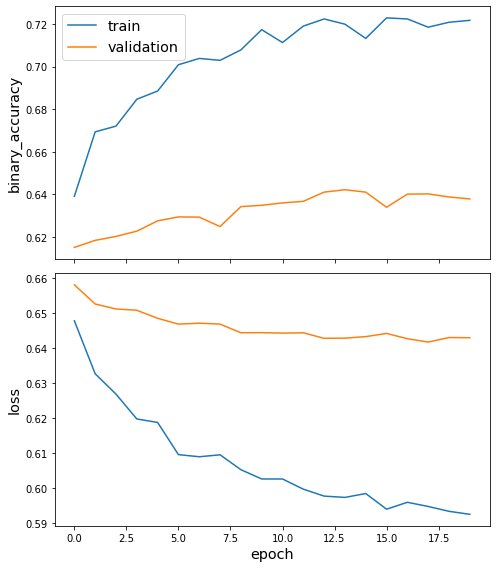

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [ ]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

172/172 [==============================] - 46s 268ms/step - loss: 0.6413 - binary_accuracy: 0.6445

Train Set Metrics of the trained model:
	loss: 0.5740
	binary_accuracy: 0.7532

Validation Set Metrics of the trained model:
	loss: 0.6422
	binary_accuracy: 0.6397

Test Set Metrics of the trained model:
	loss: 0.6413
	binary_accuracy: 0.6445


In [ ]:
num_tests = 1  # the number of times to generate predictions

In [ ]:
all_test_predictions = [
    model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
]

172/172 [==============================] - 46s 263ms/step


## Diagnosing model miscalibration

We are going to use method from scikit-learn.calibration module to calibrate the binary classifier.

In [ ]:
calibration_data = [
    calibration_curve(
        y_prob=test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True
    )
    for test_predictions in all_test_predictions
]

Let' calculate the expected calibration error on the test set before calibration.

In [ ]:
for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_pre_calibration = expected_calibration_error(
        prediction_probabilities=all_test_predictions[0],
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,
    )
    print("ECE: (before calibration) {:.4f}".format(ece_pre_calibration))

ECE: (before calibration) 0.1028


Now let's plot the reliability diagram. This is a visual aid for the diagnosis of a poorly calibrated binary classifier.

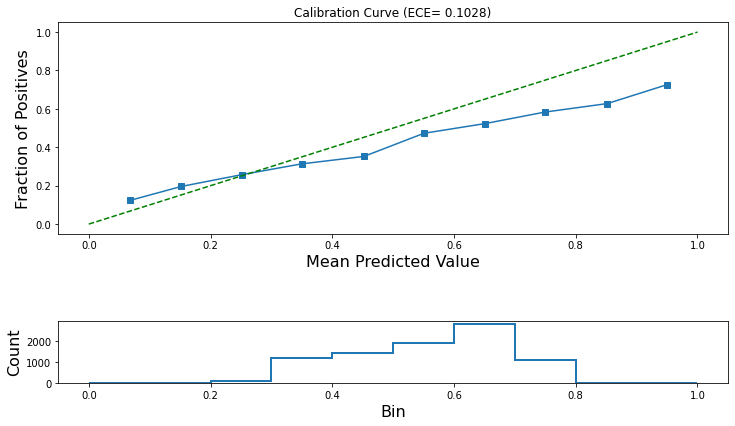

In [ ]:
plot_reliability_diagram(
    calibration_data, np.array(all_test_predictions[0]), ece=[ece_pre_calibration]
)

## Model Calibration 

Select the calibration method.

In [ ]:
use_platt = False  # True for Platt scaling or False for Isotonic Regression

In [ ]:
num_tests = 10

In [ ]:
score_model = keras.Model(inputs=x_inp, outputs=logits)

In [ ]:
if use_platt:
    all_val_score_predictions = [
        score_model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_score_predictions = [
        score_model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_probabilistic_predictions = [
        model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]
else:
    all_val_score_predictions = [
        model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_probabilistic_predictions = [
        model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]

172/172 [==============================] - 45s 261ms/step


In [ ]:
val_predictions = np.mean(np.array(all_val_score_predictions), axis=0)
val_predictions.shape

(9712, 1)

In [ ]:
# These are the uncalibrated prediction probabilities.
if use_platt:
    test_predictions = np.mean(np.array(all_test_score_predictions), axis=0)
    test_predictions.shape
else:
    test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
    test_predictions.shape

In [ ]:
if use_platt:
    # for binary classification this class performs Platt Scaling
    lr = TemperatureCalibration()
else:
    lr = IsotonicCalibration()

In [ ]:
val_predictions.shape, edge_labels_val.shape

((9712, 1), (9712,))

In [ ]:
lr.fit(val_predictions, edge_labels_val)

In [ ]:
lr_test_predictions = lr.predict(test_predictions)

TypeError: ignored

In [ ]:
lr_test_predictions.shape

(8570, 1)

In [ ]:
calibration_data = [
    calibration_curve(
        y_prob=lr_test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True
    )
]

In [ ]:
for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_post_calibration = expected_calibration_error(
        prediction_probabilities=lr_test_predictions,
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,
    )
    print("ECE (after calibration): {:.4f}".format(ece_post_calibration))

In [ ]:
plot_reliability_diagram(
    calibration_data, lr_test_predictions, ece=[ece_post_calibration]
)

As a final test, check if the accuracy of the model changes after calibration.

In [ ]:
y_pred = np.zeros(len(test_predictions))
if use_platt:
    # the true predictions are the probabilistic outputs
    test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
y_pred[test_predictions.reshape(-1) > 0.5] = 1
print(
    "Accuracy of model before calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)

Accuracy of model before calibration: 0.64


In [ ]:
y_pred = np.zeros(len(lr_test_predictions))
y_pred[lr_test_predictions[:, 0] > 0.5] = 1
print(
    "Accuracy for model after calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)

Accuracy for model after calibration: 0.66
